# AR(2) Signal with Filtered Observation and Additive White Noise

Here we import nessessary packages 

In [16]:
using Polynomials
using DSP
using Plots
pyplot()

include("wiener_filter_scalar_fft.jl")

wiener_filter_fft (generic function with 2 methods)

The parameters for this model are defined here.

In [2]:
r, t = .5, 81

# each need modulus less than one for the process to be stationary. 
# Also for the process to be rea-valued r1 and r2 are either real or complex conjugates
r1, r2 = r*exp(im*t), r*exp(im*t) 
w1, w2 = -0.1, 5
sig_v = 1.1
M_h = 50

50

## A Theoretical Solution

All the details for he formulation of `h_ana` are given in the Wiener Filtering Tutorial.

In [3]:
poly = complex(ones(5))

poly[1] = ( w2 + sig_v^2*r1*r2 )/conj(w2 + sig_v^2*r1*r2);
poly[2] = ( w1 + w1*w2 - sig_v^2*(r1 + r2 + r1*r2*conj(r1+r2)) )/conj(w2 + sig_v^2*r1*r2);
poly[3] = ( 1 + w1^2 + w2^2 + sig_v^(2)(1 + abs(r1 + r2)^2 + abs(r1*r2)^2) )/conj(w2 + sig_v^2*r1*r2);
poly[4] = ( w1 + w1*w2 - sig_v^2*conj(r1 + r2 + r1*r2*conj(r1+r2)) )/conj(w2 + sig_v^2*r1*r2);
poly[5] = 1;
poly

rho_poly = Poly(poly)

Poly((0.9931867710815842 - 0.11653341902019607im) - (0.3384086758968596 - 0.2079755743262134im)*x + (5.411991225338136 - 0.3164168307487421im)*x^2 - (0.36033912486891884 + 0.16712266910053147im)*x^3 + 1.0*x^4)

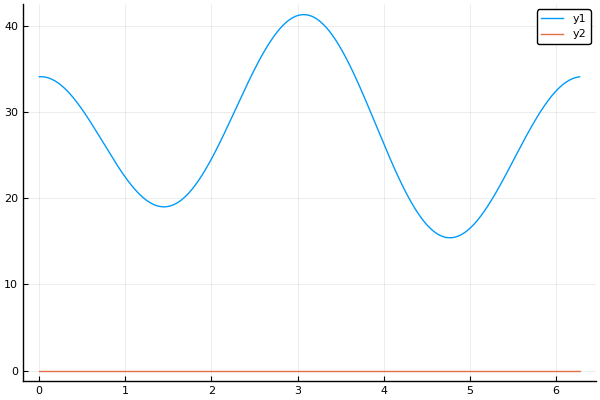

In [4]:
Nex = 1000;
Theta = 2*pi*(0:Nex - 1)/Nex
Z = exp.(im*Theta);

numerator(z) = conj(w2 + sig_v^2*r1*r2)*rho_poly(z)/z^2;

plot(Theta,[real.(numerator.(Z)) imag.(numerator.(Z))])

In [5]:
rhos = roots(rho_poly)

4-element Array{Complex{Float64},1}:
 0.016605906426244883 - 0.4597990377315101im
 0.039418948571288595 + 0.4158924645150125im
  0.07844411614078933 - 2.172030131413288im
   0.2258701537305956 + 2.3830593737303154im

In [6]:
abs.(rhos)

4-element Array{Float64,1}:
 0.4600988059396154
 0.41775638301148293
 2.1734461969702252
 2.3937396067806134

In [7]:
rho1, rho2 = rhos[ abs.(rhos) .< 1]

2-element Array{Complex{Float64},1}:
 0.016605906426244883 - 0.4597990377315101im
 0.039418948571288595 + 0.4158924645150125im

In [8]:
rho3, rho4 = [conj(rho1)^(-1); conj(rho2)^(-1)]

2-element Array{Complex{Float64},1}:
 0.07844411614078875 - 2.172030131413291im
  0.2258701537305968 + 2.383059373730319im

In [9]:
psi0 = conj(rho1*rho2/(w2 +r1*r2*sig_v^2));

alpha(n) = sum([rho1^(n-k)*rho2^k for k = 0:n]);
beta(n) = sum([r1^(n-k)*r2^k for k = 0:n]);

M_gam = 1000 + M_h + 2;

A = alpha.(0:M_gam);
B = beta.(0:M_gam);

gamma(n) = sum([conj(A[k])*B[k+n] for k = 1:1000]);

Gam = gamma.(0:M_h+2);

G = Gam[1:M_h+1] + w1*Gam[2:M_h+2] + w2*Gam[3:M_h+3]

Psi = psi0*conv(G,A[1:M_h+1]);

h_ana = [Psi[1], Psi[2] - Psi[1]*(r1+r2)];

h_temp = [Psi[n] - (r1 + r2)*Psi[n-1] + r1*r2*Psi[n-2] for n = 3 : M_h];

h_ana = [h_ana; h_temp]

50-element Array{Complex{Float64},1}:
     0.07666465823254985 - 0.1321118137026583im
     0.01566706253286143 + 0.032084957257372385im
   -0.010941947977609306 + 0.027319550878915362im
  -0.0027796791505939437 - 0.003969752462711567im
   0.0014630434884814972 - 0.00546522867708445im
  0.00041991121929887466 + 0.0003601124598648295im
 -0.00018008247674168587 + 0.0010668280809589016im
   -4.786147182397329e-5 + 3.2875425589237164e-6im
   2.0049180443661814e-5 - 0.0002044392597464346im
   1.2938767610616228e-6 - 1.350172446444478e-5im
  -2.0738862690686916e-6 + 3.863980082541936e-5im
   1.4835504080934372e-6 + 4.861093578937208e-6im
   2.6100864881738314e-7 - 7.230326071777625e-6im
                         ⋮
 -7.0260239393488196e-15 + 1.7830313876407046e-15im
   1.090384912315067e-15 + 3.3814587687081816e-15im
   1.537400150792769e-15 - 2.8184990560127654e-16im
  -1.732238076931934e-16 - 7.180318288571914e-16im
  -3.331786597643537e-16 + 2.9660431366648363e-17im
  2.6328746898130294e-17 

## Data and Numerical Solution

In [10]:
l = real.([1, -(r1 + r2), r1*r2]);
w = [1, w1, w2];

Here we generate the data

In [11]:
steps = 1*10^6
discard = 10^3
steps_tot = steps + discard

noise_sig = randn(steps_tot)
sig = zeros(steps_tot);

sig[1:2] = noise_sig[1:2];
for i = 3 : steps_tot
    sig[i] = dot(-reverse(l)[1:2],sig[i - 2:i-1]) + noise_sig[i]
end

noise_pred = sig_v*randn(steps)
pred = conv(w,sig)[discard + 1 : steps_tot] .+ noise_pred

sig = sig[discard + 1 : steps_tot];

Now we call the program I wrote to Numerically solve the Weiner filter. 

In [17]:
h_num_fft = wiener_filter_fft(pred, sig,par = 150);

Now to verify the preformance.

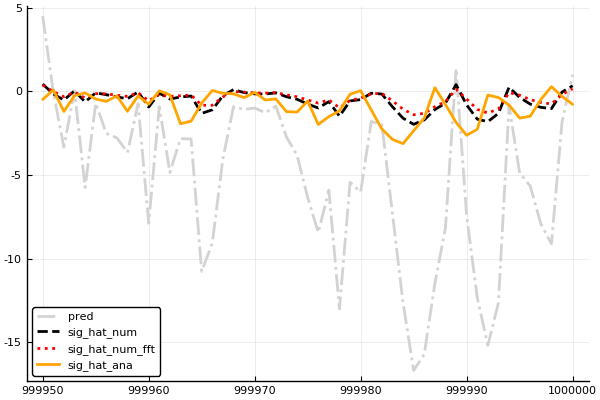

In [18]:
sig_hat_num_fft = conv(real.(h_num_fft),pred)[1:steps]
sig_hat_ana = conv(real.(h_ana),pred)[1:steps]

view = 50
start = steps - view
tim = start:start + view;

plot(tim,[pred[tim] sig_hat_num_fft[tim] sig_hat_ana[tim] sig[tim]],
    color=[:lightgrey :black :red :orange ], 
    line=(2,[:dashdot :dash :dot :solid ]),
    label=[ "pred" "sig_hat_num" "sig_hat_num_fft" "sig_hat_ana" "sig"])

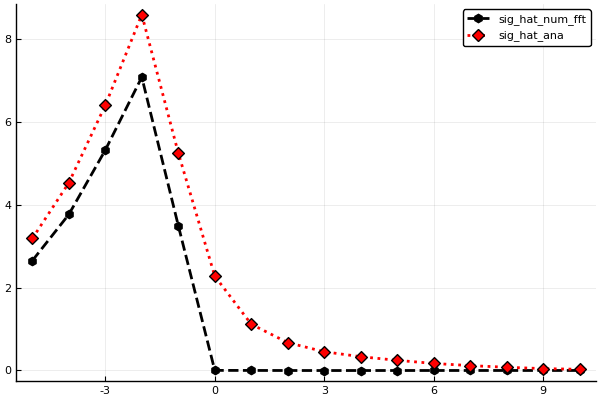

In [19]:
error_num_fft = sig .-sig_hat_num_fft
error_ana = sig .-sig_hat_ana
lags = -5:10
C_ana = my_crosscov(error_ana,pred,lags)
C_num_fft = my_crosscov(error_num_fft,pred,lags)
plot(lags, [C_num_fft C_ana],
    color=[:black :red],
    line=(2,[:dash :dot]),
    label=["sig_hat_num_fft" "sig_hat_ana"],
    marker=([:hex :d],6))